In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Initial population - continous problems

In [2]:
# Sampling using Pseudo-random
# generate 200 random numbers
np.random.seed(6345245)
N=200 # number of samples
P_random_pseudo=np.random.rand(N,N)

In [3]:
# Sampling using Quasi-random
P_random_quasi = np.random.uniform(size=(N))

In [4]:
# Sampling using Box-Muller 
# 1. generate uniformly distributed values between 0 and 1
u1 = np.random.uniform(size=(N))
u2 = np.random.uniform(size=(N))

# 2. Tranform u1 to s
ss = -np.log(u1)

# 3. Transform u2 to theta
thetas = 2*math.pi*u2

# 4. Convert s to r
rs = np.sqrt(2*ss)

# 5. Calculate x and y from r and theta
P_BM_x, P_BM_y = rs*np.cos(thetas), rs*np.sin(thetas)

In [5]:
# Sampling using the Central Limit Theorem
from scipy import stats
import random

P_CLT_x=[2.0 * math.sqrt(N) * (sum(random.randint(0,1) for x in range(N)) / N - 0.5) for x in range(N)]
P_CLT_y=[2.0 * math.sqrt(N) * (sum(random.randint(0,1) for x in range(N)) / N - 0.5) for x in range(N)]

In [6]:
# Sobol low-discrepancy-sequence (LDS)
import sobol_seq
P_sobel=sobol_seq.i4_sobol_generate(2,N)

In [7]:
# Latin Hypercube sampling
from pyDOE import *
from scipy.stats.distributions import norm
P_LHS=lhs(2, samples=N, criterion='center')

Text(0.5, 1.0, 'Latin Hypercube')

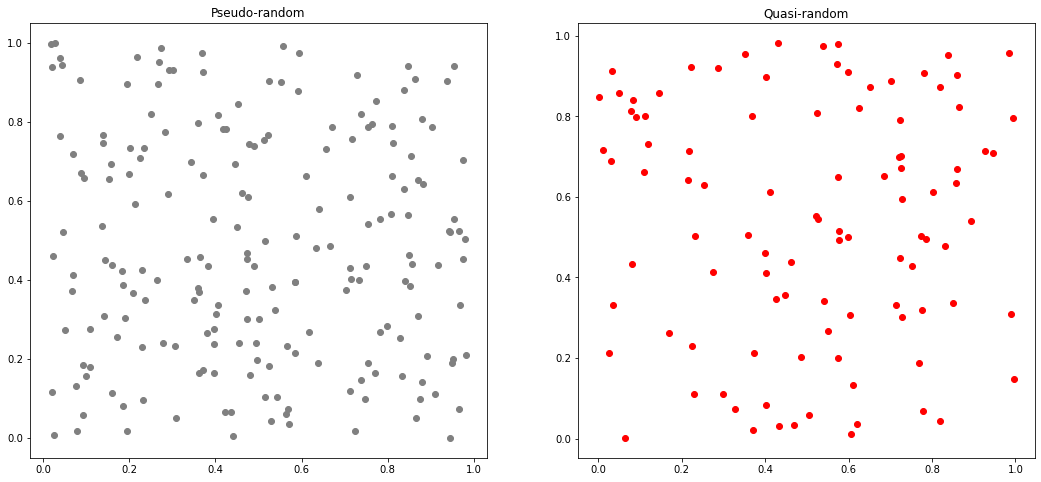

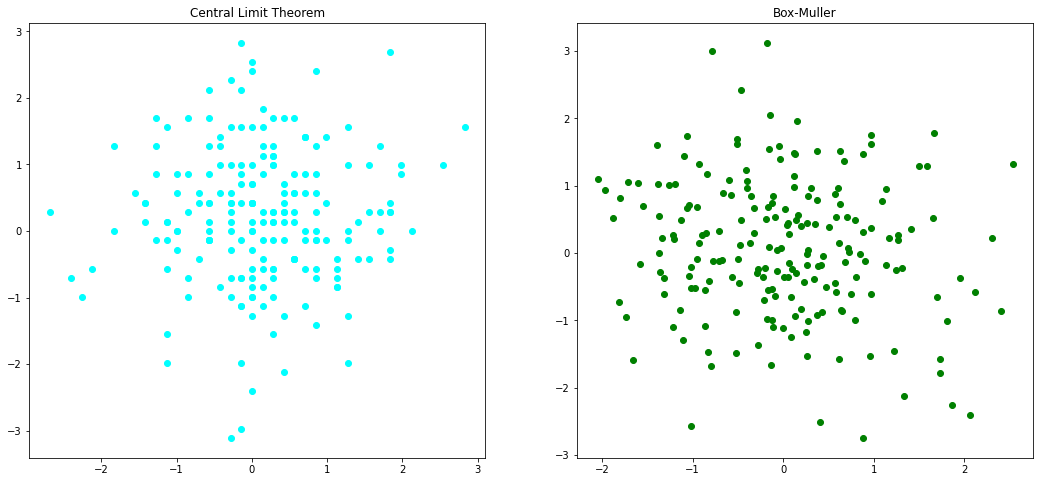

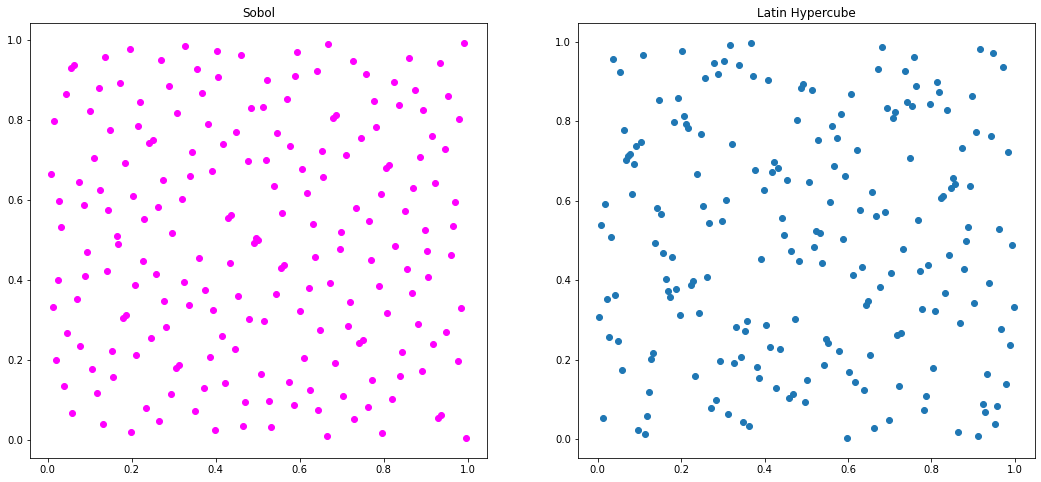

In [8]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8))
f, (ax3,ax4) = plt.subplots(ncols=2, figsize=(18,8))
f, (ax5, ax6) = plt.subplots(ncols=2, figsize=(18,8))
ax1.scatter(P_random_pseudo[:,0], P_random_pseudo[:,1], color="gray")
ax2.scatter(P_random_quasi[:100], P_random_quasi[100:], color="red")
ax3.scatter(P_CLT_x, P_CLT_y, color="cyan")
ax4.scatter(P_BM_x, P_BM_y, color="green")
ax5.scatter(P_sobel[:,0], P_sobel[:,1], color="magenta")
ax6.plot(P_LHS[:,0], P_LHS[:,1], "o")
                          
ax1.set_title("Pseudo-random")
ax2.set_title("Quasi-random")
ax3.set_title("Central Limit Theorem")
ax4.set_title("Box-Muller")
ax5.set_title("Sobol")
ax6.set_title("Latin Hypercube")

# Initial population - permutations

In [9]:
# randomly permute a sequence, or return a permuted range.
per1=np.random.permutation(10)
print(per1)

[5 7 9 0 1 6 2 4 3 8]


In [10]:
# another method
per2 = np.array([5, 4, 9, 0, 1, 2, 6, 8, 7, 3])
np.random.shuffle(per2)
print(per2)

[3 8 1 7 6 0 9 5 2 4]


In [11]:
# population of initial solution as real-value permuations 
pop_init = np.arange(50).reshape((10,5))
np.random.permutation(pop_init)

array([[15, 16, 17, 18, 19],
       [ 5,  6,  7,  8,  9],
       [25, 26, 27, 28, 29],
       [35, 36, 37, 38, 39],
       [45, 46, 47, 48, 49],
       [ 0,  1,  2,  3,  4],
       [10, 11, 12, 13, 14],
       [20, 21, 22, 23, 24],
       [30, 31, 32, 33, 34],
       [40, 41, 42, 43, 44]])

In [12]:
# population of initial solution as binary permuations 
from itertools import combinations
size=5 # number of bits in the binary string
ones=2 # number of ones in each binary string

for pos in map(set, combinations(range(size), ones)):
     print([int(i in pos) for i in range(size)], sep='\n')

[1, 1, 0, 0, 0]
[1, 0, 1, 0, 0]
[1, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[0, 1, 1, 0, 0]
[0, 1, 0, 1, 0]
[0, 1, 0, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 0, 1]
[0, 0, 0, 1, 1]


# Initial population - road routes

In [13]:
import osmnx as ox
import random
from collections import deque

In [14]:
G = ox.graph_from_place("University of Toronto")

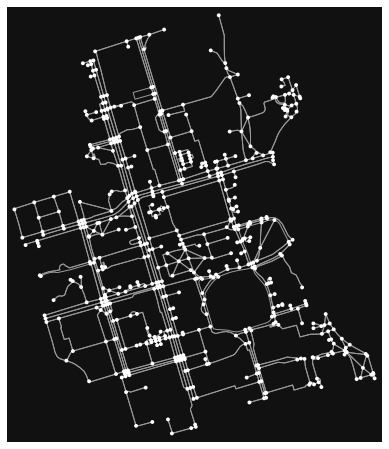

In [15]:
fig, ax = ox.plot_graph(G)

In [16]:
#
# This class is just a wrapper around networkx graph nodes to ease its usage
# 

class Node:
    # using __slots__ for optimization
    __slots__ = ['node', 'distance', 'parent', 'osmid', 'G']
    # constructor for each node
    def __init__(self ,graph , osmid, distance = 0, parent = None):
        # the dictionary of each node as in networkx graph --- still needed for internal usage
        self.node = graph[osmid]
        
        # the distance from the parent node --- edge length
        self.distance = distance
        
        # the parent node
        self.parent = parent
        
        # unique identifier for each node so we don't use the dictionary returned from osmnx
        self.osmid = osmid
        
        # the graph
        self.G = graph
    
    # returning all the nodes adjacent to the node
    def expand(self):
        children = [Node(graph = self.G, osmid = child, distance = self.node[child][0]['length'], parent = self) \
                        for child in self.node]
        return children
    
    # returns the path from that node to the origin as a list and the length of that path
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    
    # the following two methods are for dictating how comparison works

    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
            
    
    def __hash__(self):
        return hash(self.osmid)


In [17]:
# this is just a typical graph search with suffled frontier
def randomized_search(G, source, destination):
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = destination)
    
    route = [] 
    frontier = deque([origin])
    explored = set()
    while frontier:
        node = random.choice(frontier)   # here is the randomization part
        frontier.remove(node)
        explored.add(node.osmid)

        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    return route
                frontier.append(child)

    raise Exception("destination and source are not on same component")

In [18]:
# generate random route between 2 nodes 
random_route = randomized_search(G, 24959528, 1480794706)

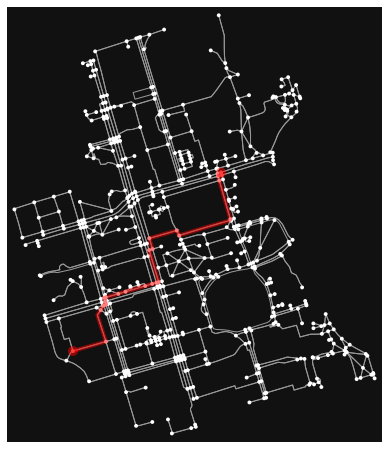

In [19]:
fig, ax = ox.plot_graph_route(G, random_route)

In [20]:
random_hexa = lambda: random.randint(0,255) # generate random hexadecimal color

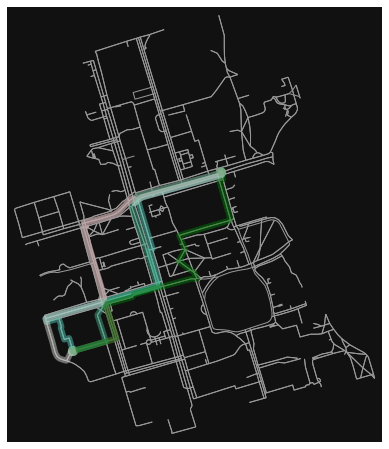

In [21]:
# generate 5 random routes with 5 different colors -- overlapping routes cancel each other color's
routes = [randomized_search(G, 24959528, 1480794706) for _ in range(5)]
rc = ['#%02X%02X%02X' % (random_hexa(),random_hexa(),random_hexa()) for _ in range(5)]
fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, route_linewidth=6, node_size=0)